In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('../../data/data_cleaned.csv')

In [3]:
X = df.drop(columns='non_functional')
y = df['non_functional']

In [4]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

In [5]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 22), (40070,), (13357, 22), (13357,), (5937, 22), (5937,))

In [7]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
    
    '''
    if grid_search == False:
        # Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])

        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        # Test Validate
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)

        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')

        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')

        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")

        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)

        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')

        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')

        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")

        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



In [8]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

## Stupid Dummy Idiot Model

Results of Cross-Validation:

Average accuracy: 0.7402295982031445        +/- 0.0027783464737094967
Average precision: 0.7833084394457173        +/- 0.0033639162026954227
**Average recall: 0.5963618765767442        +/- 0.005002666292811779
Average f1 score: 0.6771615995549407        +/- 0.004077426228519864
Average roc_auc: 0.8121279677780825        +/- 0.0053279546931561846

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7335163463938108
Train precision: 0.7814344746162928
**Train recall: 0.578498852835136
Train f1 score: 0.6648251616548433
Train roc_auc: 0.7212012735045006

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7285318559556787
Test precision: 0.7769895810241632
**Test recall: 0.5722448979591837
Test f1 score: 0.6590823617901467
Test roc_auc: 0.7165704578291493


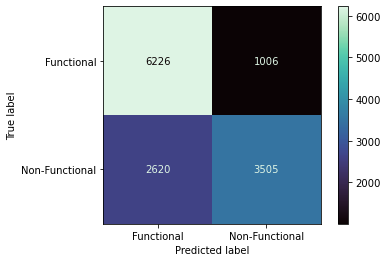

In [11]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, max_iter=1000))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

Results of Cross-Validation:

Average accuracy: 0.7577738956825555        +/- 0.004950167713787846
Average precision: 0.7337410630172154        +/- 0.007248368655924911
**Average recall: 0.7375178251995923        +/- 0.00692682111960049
Average f1 score: 0.7355908708403478        +/- 0.005007315350745493
Average roc_auc: 0.7561646360021826        +/- 0.0048085443604879465

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7583289660851987
Test precision: 0.734726948630692
**Test recall: 0.7402448979591837
Test f1 score: 0.7374756018217308
Test roc_auc: 0.7569449047318042


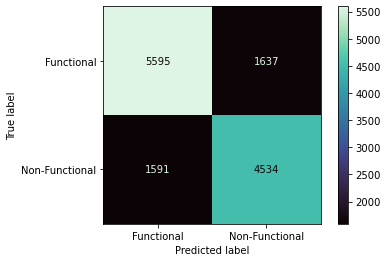

In [12]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

evaluate(dt, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

Results of Cross-Validation:

Average accuracy: 0.8142001497379585        +/- 0.005237262147072506
Average precision: 0.822432297441831        +/- 0.008215468603354167
**Average recall: 0.7568010101306955        +/- 0.009703850381972872
Average f1 score: 0.7881972882154242        +/- 0.006201610985087064
Average roc_auc: 0.8916793348325548        +/- 0.0030553141410370947

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8179980534551171
Test precision: 0.8255199154035954
**Test recall: 0.764734693877551
Test f1 score: 0.7939655903042632
Test roc_auc: 0.8139215504785985


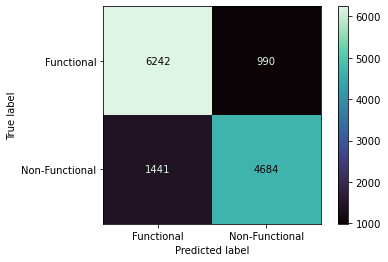

In [13]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

Results of Cross-Validation:

Average accuracy: 0.8134764162715248        +/- 0.004130554752118509
Average precision: 0.8220466579245258        +/- 0.006083035139407714
**Average recall: 0.7552715375179148        +/- 0.008101609047447599
Average f1 score: 0.7872106040727355        +/- 0.005041048249127777
Average roc_auc: 0.8918217031947048        +/- 0.002296845391185429

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8188964587856554
Test precision: 0.8269230769230769
**Test recall: 0.7652244897959184
Test f1 score: 0.7948783176460612
Test roc_auc: 0.8147886829510566


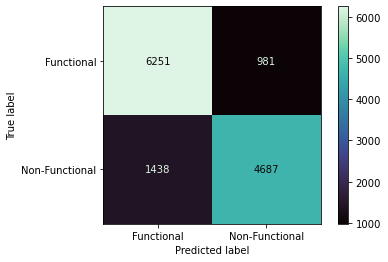

In [14]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=5))
])
evaluate(rf, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

## Slightly less dummy models

Results of Cross-Validation:

Average accuracy: 0.7482904916396306        +/- 0.0028117707226265384
Average precision: 0.7900477661794632        +/- 0.0018429432142914293
**Average recall: 0.6115474473657789        +/- 0.007451429555809331
Average f1 score: 0.6894076017551017        +/- 0.0049591131258770165
Average roc_auc: 0.8202443573403901        +/- 0.0033093557321074193

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7497130022460694
Train precision: 0.7910542232224488
**Train recall: 0.6144433519064787
Train f1 score: 0.691652574942352
Train roc_auc: 0.7389667595775732

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7423074043572658
Test precision: 0.7811779501152798
**Test recall: 0.6084897959183674
Test f1 score: 0.6841042584434656
Test roc_auc: 0.7320656944193606


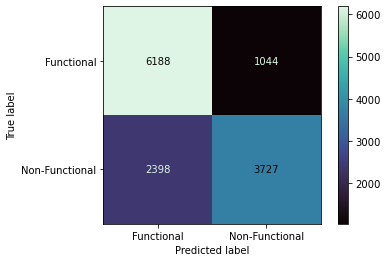

In [16]:
logreg2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, penalty='l1', solver = 'liblinear', max_iter=1000))
])

evaluate(logreg2, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

Results of Cross-Validation:

Average accuracy: 0.7474419765410532        +/- 0.002470550271178383
Average precision: 0.7898704946058936        +/- 0.0006842906890581806
**Average recall: 0.6092532309875851        +/- 0.007082866273016163
Average f1 score: 0.6878817722044015        +/- 0.004604418740762549
Average roc_auc: 0.819513894244109        +/- 0.0035418523650038725

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7466433740953332
Train precision: 0.7874365482233503
**Train recall: 0.6101278269419862
Train f1 score: 0.6875346260387811
Train roc_auc: 0.7357981535003996

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7396870554765291
Test precision: 0.7795608108108109
**Test recall: 0.6027755102040816
Test f1 score: 0.6798637326213055
Test roc_auc: 0.7292085515622179


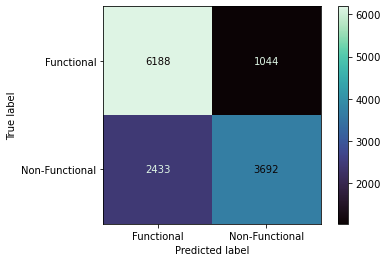

In [17]:
logreg3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, solver = 'liblinear', max_iter=1000))
])

evaluate(logreg3, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Results of Cross-Validation:

Average accuracy: 0.7482405789867732        +/- 0.002876588776325215
Average precision: 0.7899754747252306        +/- 0.0018110771791149851
**Average recall: 0.6114927876471423        +/- 0.007515241444927253
Average f1 score: 0.6893456308149278        +/- 0.005038490689583234
Average roc_auc: 0.8202122551030652        +/- 0.0032577240113827056

++++++++++++++++++++


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7497878712253556
Train precision: 0.7913441238564392
**Train recall: 0.6142794712116246
Train f1 score: 0.6916594907122647
Train roc_auc: 0.7390226615385452

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7425320056899004
Test precision: 0.7816694630872483
**Test recall: 0.6084897959183674
Test f1 score: 0.6842926650142293
Test roc_auc: 0.7322731059237855


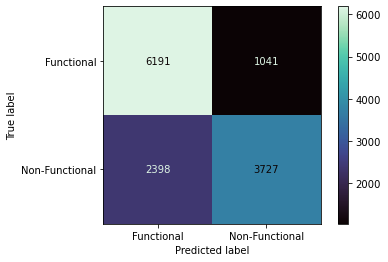

In [18]:
logreg3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, solver = 'newton-cg', max_iter=1000))
])

evaluate(logreg3, X_train, X_test, y_train, y_test, grid_search=False, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7402295982031445        +/- 0.0027783464737094967
Average precision: 0.7833084394457173        +/- 0.0033639162026954227
**Average recall: 0.5963618765767442        +/- 0.005002666292811779
Average f1 score: 0.6771615995549407        +/- 0.004077426228519864
Average roc_auc: 0.8121279677780825        +/- 0.0053279546931561846

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7335163463938108
Train precision: 0.7814344746162928
**Train recall: 0.578498852835136
Train f1 score: 0.6648251616548433
Train roc_auc: 0.7212012735045006

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7285318559556787
Test precision: 0.7769895810241632
**Test recall: 0.5722448979591837
Test f1 score: 0.6590823617901467
Test roc_auc: 0.7165704578291493


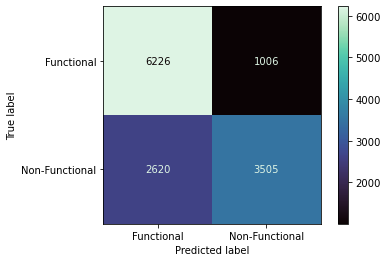

In [20]:
logreg4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, max_iter=500))
])

evaluate(logreg4, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [ ]:
# test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        print('Best Params: {}'.format(gs_pipe.best_params_))
        print('Best Score: {}'.format(gs_pipe.best_score_))

        scores = gs_pipe.cv_results_
    return scores

In [21]:
# dt_test_list = [{'name':'dt', 'type':DecisionTreeClassifier(), 'params':{'dt__random_state': [396],
#                                                                       'dt__criterion': ['gini', 'entropy'],
#                                                                      'dt__max_features': [None, 'sqrt', 'log2'],
#                                                                      'dt__max_depth':[20,40,80]}}]
# #fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
# dt_tests = model_tests(X_train_processed, y_train, test_list)

Results of Cross-Validation:

Average accuracy: 0.7667831295233342        +/- 0.004808871056290031
Average precision: 0.7629096456331637        +/- 0.011803755176704223
**Average recall: 0.710751032589813        +/- 0.01002098532737539
Average f1 score: 0.7357724132902197        +/- 0.004163005391149528
Average roc_auc: 0.78036064062519        +/- 0.008118255845425424

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9294983778387821
Train precision: 0.9495324931761426
**Train recall: 0.8931497869550967
Train f1 score: 0.920478536242083
Train roc_auc: 0.9266107324777322

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7676873549449726
Test precision: 0.7624175060784995
**Test recall: 0.7167346938775511
Test f1 score: 0.7388706555583608
Test roc_auc: 0.7637877009210765


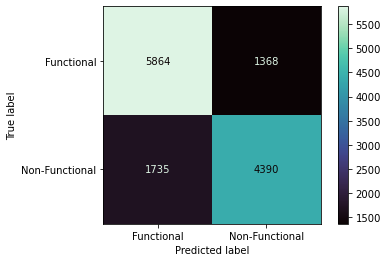

In [22]:
dt2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=20))
])

evaluate(dt2, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

Results of Cross-Validation:

Average accuracy: 0.7513351634639381        +/- 0.004048313089809771
Average precision: 0.8144512911659344        +/- 0.012650507838438409
**Average recall: 0.5907905087217606        +/- 0.020033101916462074
Average f1 score: 0.6844450934580009        +/- 0.009960356481590544
Average roc_auc: 0.8087657406247469        +/- 0.009053511381641321

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7787871225355628
Train precision: 0.842051876539632
**Train recall: 0.6348738118649623
Train f1 score: 0.7239317304098668
Train roc_auc: 0.7673542005474416

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7536123380998727
Test precision: 0.8091186736474695
**Test recall: 0.6055510204081632
Test f1 score: 0.6926883929405173
Test roc_auc: 0.7422804880801879


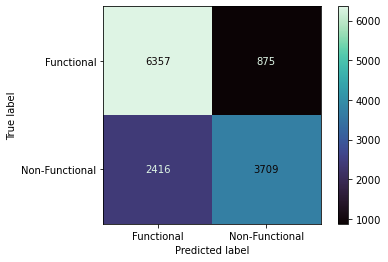

In [23]:
dt3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=10))
])

evaluate(dt3, X_train, X_test, y_train, y_test, grid_search=False, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7600948340404292        +/- 0.005363346223786279
Average precision: 0.7380681541140518        +/- 0.007759109912472844
**Average recall: 0.7362614274093129        +/- 0.006398764904479241
Average f1 score: 0.7371336065961267        +/- 0.005308276432503022
Average roc_auc: 0.7602808724438996        +/- 0.0044669571149520415

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9912652857499377
Train precision: 0.9927011305015915
**Train recall: 0.9881459630722168
Train f1 score: 0.9904183092422252
Train roc_auc: 0.9910174770332597

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7601257767462754
Test precision: 0.738526865915401
**Test recall: 0.7382857142857143
Test f1 score: 0.7384062704114958
Test roc_auc: 0.7584542509481671


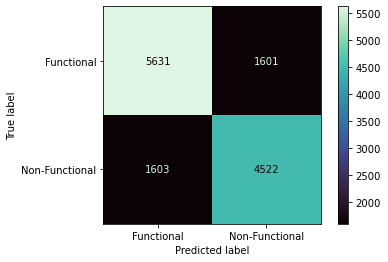

In [24]:
dt4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=30))
])

evaluate(dt4, X_train, X_test, y_train, y_test, grid_search=False, cv=5)

In [ ]:

# dt_tests_df = pd.DataFrame(dt_tests)

In [ ]:
# dt_tests_df.head()

In [25]:
rf_test_list = {
    'rf__n_estimators': [10, 50, 100],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth':[None, 5, 20],
    'rf__class_weight' : [None, 'balanced']}
#fit_intercept=False, C= 1e12, solver='liblinear'

In [26]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

In [16]:
cv = GridSearchCV(pipeline, param_grid=rf_test_list)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('ii',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           random_state=396)),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['id',
                                                                          'amount_tsh',
                                                                          'gps_height',
                                                 

In [19]:
print('Best Params: {}'.format(cv.best_params_))
print('Best Score: {}'.format(cv.best_score_))

cv_scores = cv.cv_results_
 

Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__n_estimators': 100}
Best Score: 0.8163963064636885


Output from above: Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__n_estimators': 100}
Best Score: 0.8163963064636885

In [27]:
rf_test2_list = {
    'rf__n_estimators': [125,150],
    'rf__criterion': ['entropy'],
    'rf__max_depth':[25,50],
    'rf__class_weight' : ['balanced']}

In [21]:
cv2 = GridSearchCV(pipeline, param_grid=rf_test2_list)
cv2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('ii',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           random_state=396)),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['id',
                                                                          'amount_tsh',
                                                                          'gps_height',
                                                 

In [22]:
print('Best Params: {}'.format(cv2.best_params_))
print('Best Score: {}'.format(cv2.best_score_))

cv2_scores = cv2.cv_results_
 

Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__n_estimators': 150}
Best Score: 0.816446219116546


Output from above: Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__n_estimators': 150}
Best Score: 0.816446219116546

In [28]:
estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5, n_estimators=200))
])

Results of Cross-Validation:

Average accuracy: 0.7373596206638383        +/- 0.004437316248123621
Average precision: 0.7720927624358531        +/- 0.004013340337579525
**Average recall: 0.6031349377492339        +/- 0.010638972672257375
Average f1 score: 0.6771892321438824        +/- 0.007460839883088123
Average roc_auc: 0.8104246955376488        +/- 0.0041031790164184085

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7406538557524333
Train precision: 0.7897203104407673
**Train recall: 0.5892057248989402
Train f1 score: 0.6748842447753722
Train roc_auc: 0.7286223441623906

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7372164408175489
Test precision: 0.7862929713159623
**Test recall: 0.5862857142857143
Test f1 score: 0.6717171717171717
Test roc_auc: 0.7256649810366623


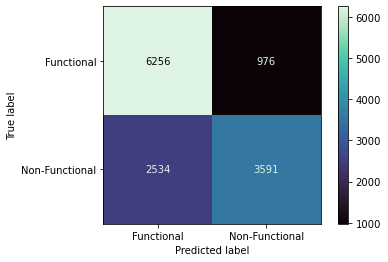

In [29]:
evaluate(estimator, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [30]:
estimator2 = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=10, n_estimators=150))
])

Results of Cross-Validation:

Average accuracy: 0.7788619915148491        +/- 0.0027727365934277276
Average precision: 0.814016437333698        +/- 0.003370961178799237
**Average recall: 0.6687962524676312        +/- 0.009538832594568523
Average f1 score: 0.7342431972612486        +/- 0.005077345229238339
Average roc_auc: 0.8591773892582232        +/- 0.0029279138803406696

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.79940104816571
Train precision: 0.8432736025675315
**Train recall: 0.6889544411668306
Train f1 score: 0.7583428537069328
Train roc_auc: 0.7906268254354645

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7798158269072396
Test precision: 0.8181454836131095
**Test recall: 0.6684081632653062
Test f1 score: 0.7357354658999012
Test roc_auc: 0.7712892586238035


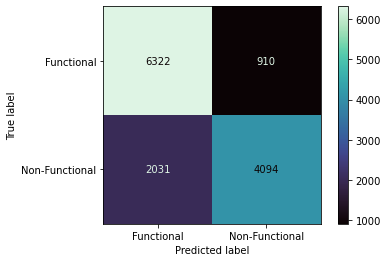

In [32]:
evaluate(estimator2, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [33]:
estimator_rf_basic = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=369))
])

Results of Cross-Validation:

Average accuracy: 0.8134015472922386        +/- 0.003941677756501877
Average precision: 0.8226913986571345        +/- 0.006334886670623301
**Average recall: 0.7541788652767722        +/- 0.009625544416807096
Average f1 score: 0.7868915512581947        +/- 0.005123214517301098
Average roc_auc: 0.8918058322566587        +/- 0.002209489528770924

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9999251310207138
Train precision: 1.0
**Train recall: 0.9998361193051458
Train f1 score: 0.9999180529378021
Train roc_auc: 0.999918059652573

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8197199970053156
Test precision: 0.8273736128236745
**Test recall: 0.7668571428571429
Test f1 score: 0.7959667852906287
Test roc_auc: 0.8156741466498104


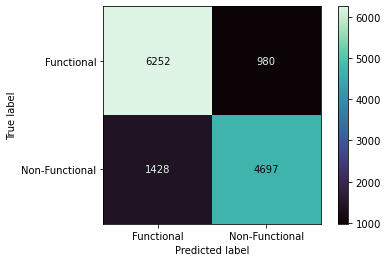

In [35]:
evaluate(estimator_rf_basic, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [38]:
estimator_rf_best = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=100,  random_state=369))
])

Results of Cross-Validation:

Average accuracy: 0.8149737958572499        +/- 0.003961222343778333
Average precision: 0.8461435807672849        +/- 0.003972011236290002
**Average recall: 0.7272474221990363        +/- 0.008978221827099694
Average f1 score: 0.7821714162390789        +/- 0.005596031071483234
Average roc_auc: 0.8949406589234747        +/- 0.0017927355345901891

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9409034190167207
Train precision: 0.9789638177665585
**Train recall: 0.8897629192614444
Train f1 score: 0.9322344322344323
Train roc_auc: 0.936840658307436

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8185221232312645
Test precision: 0.8481655691439323
**Test recall: 0.736
Test f1 score: 0.788111888111888
Test roc_auc: 0.8122063053097345


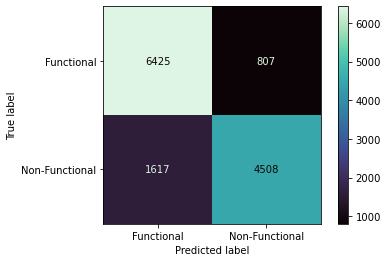

In [39]:
evaluate(estimator_rf_best, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [ ]:
def evaluate2(estimator, X_tr, X_te, y_tr, y_te, cross_val=True, cv=5):
    '''
    
    '''
    if cross_val == True:
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])

        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}')
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
    
        categories = ['Functional', 'Non-Functional']
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories)
    
        print("Training Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}")

        print("<>"*10)
        print("Testing Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")